# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In this recipe, we will cover:

- Downloading data for the Black-Litterman method
- Constructing the prior return vector based on market equilibrium
- Two ways of constructing the uncertainty matrix
- Combining Black-Litterman with mean-variance optimization

## Downloading data

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
tickers = ["MSFT", "AMZN", "NAT", "BAC", "DPZ", "DIS", "KO", "MCD", "COST", "SBUX"]

In [3]:
ohlc = yf.download(tickers, period="max")
prices = ohlc["Adj Close"]
prices.tail()

[*********************100%***********************]  10 of 10 completed


,AMZN,BAC,COST,DIS,DPZ,KO,MCD,MSFT,NAT,SBUX
Date,,,,,,,,,,
2021-12-06,3427.370117,44.150002,533.200012,150.369995,517.080017,54.910000,255.789993,326.190002,1.83,113.360001
2021-12-07,3523.290039,44.709999,542.020020,150.809998,537.429993,55.209999,259.910004,334.920013,1.98,116.260002
2021-12-08,3523.159912,44.160000,530.109985,153.339996,534.169983,55.000000,259.579987,334.970001,2.09,116.250000
2021-12-09,3483.419922,44.490002,524.330017,152.940002,530.289978,54.860001,262.339996,333.100006,2.02,115.349998
2021-12-10,3444.239990,44.520000,558.820007,152.710007,534.419983,56.279999,264.970001,342.540009,2.01,116.730003


In [4]:
market_prices = yf.download("SPY", period="max")["Adj Close"]
market_prices.head()

[*********************100%***********************]  1 of 1 completed


Date
1993-01-29    25.717392
1993-02-01    25.900303
1993-02-02    25.955166
1993-02-03    26.229536
1993-02-04    26.339281
Name: Adj Close, dtype: float64

In [5]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps

{'MSFT': 2571783372800,
 'AMZN': 1746739396608,
 'NAT': 345647648,
 'BAC': 364355223552,
 'DPZ': 19431671808,
 'DIS': 277574877184,
 'KO': 243096944640,
 'MCD': 197997510656,
 'COST': 246900097024,
 'SBUX': 136947638272}

## Constructing the prior

In [6]:
import pypfopt
pypfopt.__version__

'1.4.2'

In [7]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

2.8047177606779634

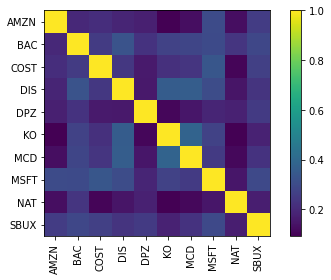

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

In [9]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMZN    0.184617
BAC     0.109424
COST    0.080369
DIS     0.098142
DPZ     0.049539
KO      0.065261
MCD     0.067481
MSFT    0.145039
NAT     0.053940
SBUX    0.083492
dtype: float64

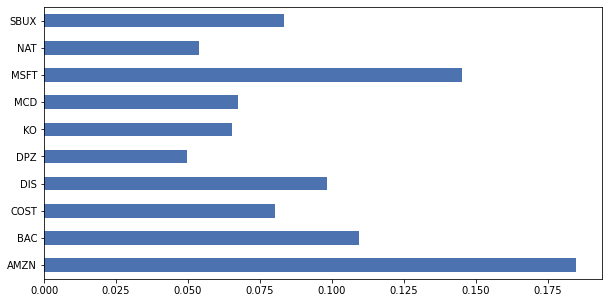

In [10]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [11]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [12]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [13]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

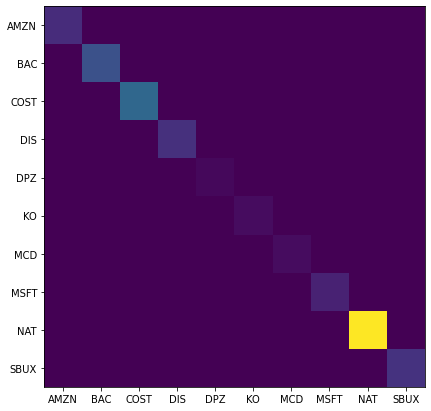

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [15]:
np.diag(bl.omega)

array([0.00455303, 0.00892498, 0.01203978, 0.00495835, 0.00081558,
       0.00115627, 0.00124785, 0.0034253 , 0.03615571, 0.00535406])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [16]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [17]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.015625, 0.022500000000000006, 0.015625, 0.0056250000000000015, 0.0025000000000000005, 0.0025000000000000005, 0.0025000000000000005, 0.00039999999999999986, 0.16000000000000003, 0.0225]


## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [18]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [19]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMZN    0.157300
BAC     0.138869
COST    0.063465
DIS     0.073035
DPZ     0.102903
KO      0.008299
MCD     0.094059
MSFT    0.104414
NAT     0.062176
SBUX    0.084480
dtype: float64

We can visualise how this compares to the prior and our views:

In [20]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
AMZN,0.184617,0.157300,0.10
BAC,0.109424,0.138869,0.30
COST,0.080369,0.063465,0.05
DIS,0.098142,0.073035,0.05
DPZ,0.049539,0.102903,0.20
KO,0.065261,0.008299,-0.05
MCD,0.067481,0.094059,0.15
MSFT,0.145039,0.104414,0.10
NAT,0.053940,0.062176,0.50
SBUX,0.083492,0.084480,0.10


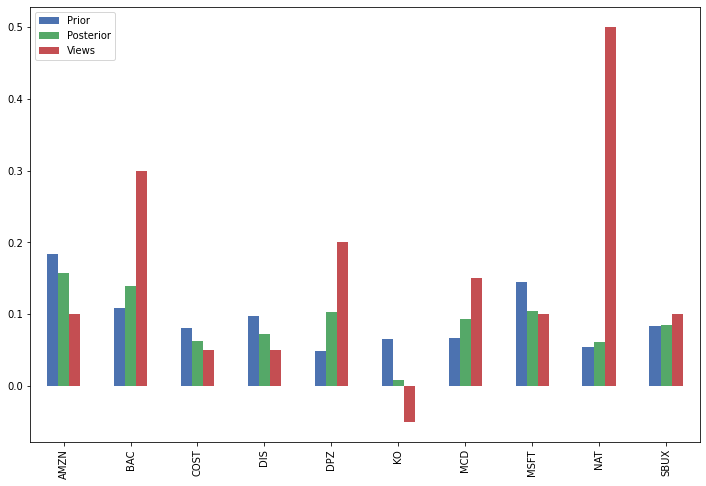

In [21]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

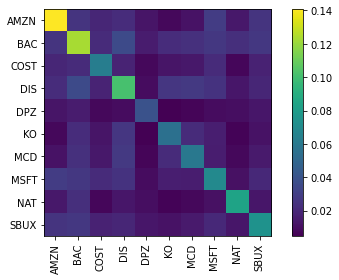

In [22]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [23]:
from pypfopt import EfficientFrontier, objective_functions

In [24]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/home/timcosas/stock_analysis/pypfopt/efficient_frontier/efficient_frontier.py:252: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('AMZN', 0.19812),
             ('BAC', 0.16881),
             ('COST', 0.05728),
             ('DIS', 0.06569),
             ('DPZ', 0.13142),
             ('KO', 0.0),
             ('MCD', 0.11077),
             ('MSFT', 0.12201),
             ('NAT', 0.05711),
             ('SBUX', 0.08879)])

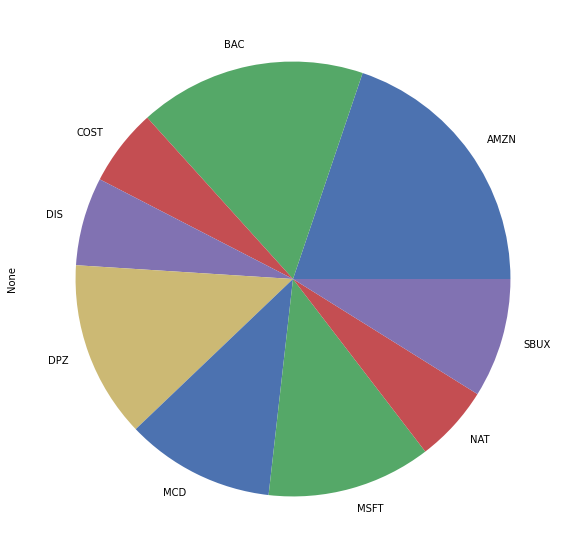

In [25]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [26]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

NameError: Solver GLPK_MI is not installed. 